In [1]:
import gym
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import rl_utils

In [2]:
class PolicyNet(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim, action_dim):
        super(PolicyNet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, action_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return F.softmax(self.fc2(x), dim=1)

In [3]:
class ValueNet(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim):
        super(ValueNet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return self.fc2(x)

In [4]:
class ActorCritic:
    def __init__(self, state_dim, hidden_dim, action_dim, actor_lr, critic_lr,
                 gamma, device):
        # 策略网络
        self.actor = PolicyNet(state_dim, hidden_dim, action_dim).to(device)
        self.critic = ValueNet(state_dim, hidden_dim).to(device)  # 价值网络
        # 策略网络优化器
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(),
                                                lr=actor_lr)
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(),
                                                 lr=critic_lr)  # 价值网络优化器
        self.gamma = gamma
        self.device = device

    def take_action(self, state):
        '''
        	•	假设 state.shape = (4,)（典型的 CartPole）
            •	[state] 会变成 shape = (1, 4)，但是Python list 包裹的 NumPy 数组，不稳定,可能出错，可以写
            •	torch.tensor([state]) 的内部解析可能导致 shape 不一致
            •	.unsqueeze(0) 是标准做法，向前添加 batch 维度，得到 (1, 4)，保证格式一致、不会出错
        '''
        state = torch.tensor(state, dtype=torch.float).unsqueeze(0).to(self.device)
        # state = torch.tensor([state], dtype=torch.float).to(self.device)

        probs = self.actor(state)
        action_dist = torch.distributions.Categorical(probs)
        action = action_dist.sample()
        return action.item()

    def update(self, transition_dict):
        states = torch.tensor(transition_dict['states'],
                              dtype=torch.float).to(self.device)
        actions = torch.tensor(transition_dict['actions']).view(-1, 1).to(
            self.device)
        rewards = torch.tensor(transition_dict['rewards'],
                               dtype=torch.float).view(-1, 1).to(self.device)
        next_states = torch.tensor(transition_dict['next_states'],
                                   dtype=torch.float).to(self.device)
        dones = torch.tensor(transition_dict['dones'],
                             dtype=torch.float).view(-1, 1).to(self.device)

        # 时序差分目标
        td_target = rewards + self.gamma * self.critic(next_states) * (1 -
                                                                       dones)
        td_delta = td_target - self.critic(states)  # 时序差分误差
        log_probs = torch.log(self.actor(states).gather(1, actions))
        actor_loss = torch.mean(-log_probs * td_delta.detach())
        # 均方误差损失函数
        '''
            在 DQN 及其变种（如 Double DQN、Dueling DQN）中，目标网络（target network）并非每次迭代都更新，
            而是 每隔 target_update 步，才将当前主网络（q_net）的参数复制给目标网络（target_q_net）一次，以保持目标稳定性。
        '''
        critic_loss = torch.mean( 
            F.mse_loss(self.critic(states), td_target.detach())) 
            # .detach() 的意思是：从计算图中剪断这个变量的梯度流，让它变成“定值”，只作为目标，不参与反向传播，保证训练稳定。
        self.actor_optimizer.zero_grad()
        self.critic_optimizer.zero_grad()
        actor_loss.backward()  # 计算策略网络的梯度
        critic_loss.backward()  # 计算价值网络的梯度
        self.actor_optimizer.step()  # 更新策略网络的参数
        self.critic_optimizer.step()  # 更新价值网络的参数

当算法中使用目标网络或引入 bootstrapping（如 DQN、Actor-Critic）时，detach() 是必须的，因为这些算法会用“未来估计的 Q 值”来当作目标，如果不加 detach()，梯度就会从这个目标值反传回去，影响目标网络或未来状态的估计，导致学习不稳定甚至崩掉。而 REINFORCE 算法是纯策略梯度法，只对当前策略输出的 log π 求梯度，没有用未来状态来估计当前动作的目标值，因此不需要 detach()，也没有目标网络。一句话总结：有没有 detach()，核心看有没有用“估计的未来值”当作训练目标。

In [5]:
actor_lr = 1e-3
critic_lr = 1e-2
num_episodes = 1000
hidden_dim = 128
gamma = 0.98
device = torch.device("cuda") if torch.cuda.is_available() else torch.device(
    "cpu")

env_name = 'CartPole-v1'
env = gym.make(env_name)

env.reset(seed=0)
env.action_space.seed(0)
env.observation_space.seed(0)

torch.manual_seed(0)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n
agent = ActorCritic(state_dim, hidden_dim, action_dim, actor_lr, critic_lr,
                    gamma, device)

return_list = rl_utils.train_on_policy_agent(env, agent, num_episodes)


Iteration 0:   0%|          | 0/100 [00:00<?, ?it/s]/Users/qinghuan/anaconda3/envs/wenet/lib/python3.9/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
/var/folders/k6/llfnq3ms0cj9qvwt94zkq4ch0000gn/T/ipykernel_30603/153793239.py:31: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:233.)
  states = torch.tensor(transition_dict['states'],
Iteration 9: 100%|██████████| 100/100 [00:02<00:00, 36.61it/s, episode=1000, return=485.800]


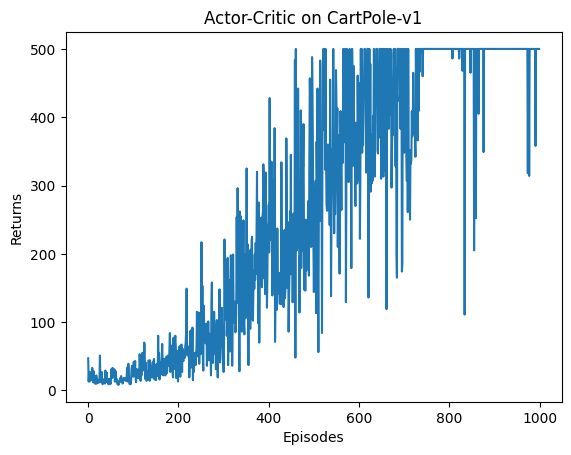

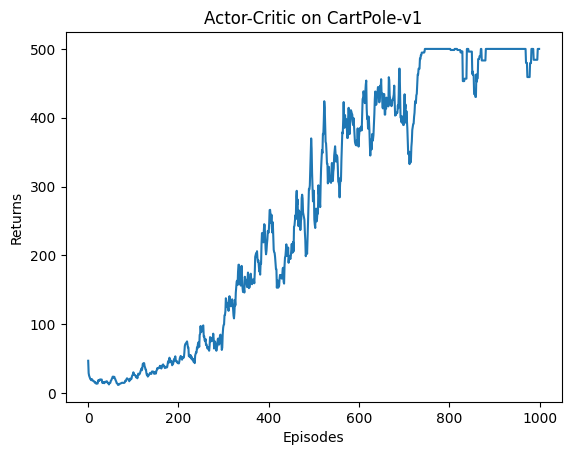

In [6]:
episodes_list = list(range(len(return_list)))
plt.plot(episodes_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('Actor-Critic on {}'.format(env_name))
plt.show()

mv_return = rl_utils.moving_average(return_list, 9)
plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('Actor-Critic on {}'.format(env_name))
plt.show()